In [1]:
!pip install torchinfo

In [2]:
!mkdir images
!mkdir models

In [3]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

from torchinfo import summary

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import clear_output, display

In [4]:
PATH = "../input/gan-getting-started"
IMG_SIZE = (256, 256)

In [5]:
class ImageDataset(Dataset):
    def __init__(self, dir_path, transform=None):
        super().__init__()
        
        self.transform = transform
        self.images = []
        
        for fn in tqdm(os.listdir(dir_path)):
            img = Image.open(os.path.join(dir_path, fn))
            self.images.append(img)
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        
        if self.transform is not None:
            image = self.transform(image=np.array(image))["image"]
            
        return image

In [6]:
class MonetDataset(Dataset):
    def __init__(self, datasets, augs=[]):
        super().__init__()
        
        self.datasets = datasets
        self.augs = augs
        self.init_augs = [dataset.transform for dataset in datasets]
            
    def __len__(self):
        return min([len(dataset) for dataset in self.datasets])
    
    def set_train_mode(self):
        for dataset, aug in zip(self.datasets, self.augs):
            dataset.transform = aug
            
    def set_test_mode(self):
        for dataset, aug in zip(self.datasets, self.init_augs):
            dataset.transform = aug
    
    def __getitem__(self, idx):
        _return = []
        for dataset in self.datasets:
            idx = np.random.choice(len(dataset))
            _return.append(dataset[idx])
            
        return tuple(_return)

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(*IMG_SIZE),
    A.Normalize(mean=[.5]*3, std=[.5]*3),
    ToTensorV2(),
])

# aug = A.Compose ([
#     A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=.5),
#     A.HorizontalFlip(p=.5),
#     A.ShiftScaleRotate(rotate_limit=10),
#     A.RandomBrightnessContrast(brightness_limit=.2, contrast_limit=.2),
#     transform
# ])

In [8]:
path_images = os.path.join(PATH, "photo_jpg")
path_monets = os.path.join(PATH, "monet_jpg")
dataset_photos = ImageDataset(path_images, transform)
dataset_monet = ImageDataset(path_monets, transform)
dataset = MonetDataset([dataset_photos, dataset_monet])

  0%|          | 0/7038 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [9]:
from torchvision.transforms import ToPILImage

to_pil = ToPILImage()
to_img = lambda x: to_pil(x*.5 + .5)

In [10]:
def plot_images_grid(imgs, figsize=(10, 10)):
    n = int(np.ceil(np.sqrt(len(imgs))))
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(n, n),
                     axes_pad=0.1,
                     )
    for img, ax in zip(imgs, grid):
        ax.imshow(img)
    
    for ax in grid:
        ax.set_axis_off()
        
    plt.show()

In [11]:
# dataset_monet.transform = aug
# print('Augmentated')
# plot_images_grid([to_img(dataset_monet[i]) for i in range(25)], figsize=(20, 20))
# dataset_monet.transform = transform
# print('Original')
# plot_images_grid([to_img(dataset_monet[i]) for i in range(25)], figsize=(20, 20))

In [12]:
def display_pair(img, monet, gen=None, figsize=(10, 10)):
    n_rows = 3 if gen is not None else 2
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(1, n_rows),
                     axes_pad=0.1,
                     )
    grid_iter = iter(grid)
    
    ax_img = next(grid_iter)
    ax_img.imshow(img)
    ax_img.set_axis_off()
    ax_img.set_title('Image')
    
    ax_monet = next(grid_iter)
    ax_monet.imshow(monet)
    ax_monet.set_axis_off()
    ax_monet.set_title('Monet')
    
    if n_rows > 2:
        ax_gen = next(grid_iter)
        ax_gen.imshow(gen)
        ax_gen.set_axis_off()
        ax_gen.set_title('Generated')
    
    plt.show()

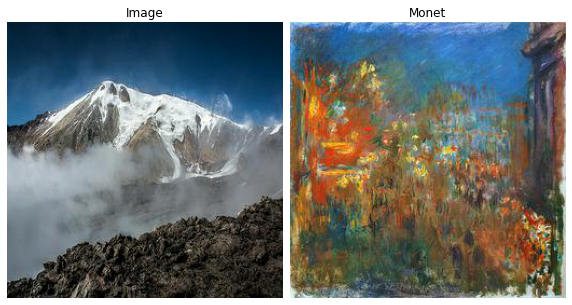

In [13]:
photo, monet = dataset[0]
display_pair(to_img(photo), to_img(monet))

In [14]:
BATCH_SIZE = 1
WORKERS = 2

In [15]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=WORKERS)

## Model

In [16]:
def Upsample(in_ch, out_ch, r=2, dropout_ratio=0.5):
    modules = list()
    
    if dropout_ratio > 0:
        modules.append(nn.Dropout(dropout_ratio))
        
    modules += [
        nn.PixelShuffle(2),
        
        nn.ReflectionPad2d(1),
        nn.Conv2d(in_ch//r**2, out_ch, 3, 1),
        nn.InstanceNorm2d(out_ch),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        
        nn.ReflectionPad2d(1),
        nn.Conv2d(out_ch, out_ch, 3, 1),
        nn.InstanceNorm2d(out_ch),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
    ]
    return nn.Sequential(*modules)
    

In [17]:
def Downsample(in_ch, out_ch, kernel=3, stride=2, padding=1):
    return nn.Sequential(
        nn.ReflectionPad2d(padding),
        nn.Conv2d(in_ch, out_ch, kernel, stride, bias=True),
        nn.InstanceNorm2d(out_ch),
        nn.LeakyReLU(negative_slope=0.2, inplace=True)
    )

In [18]:
class Resblock(nn.Module):
    def ConvBlock(self, in_ch):
        return nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_ch, in_ch, 3, 1, bias=True),
            nn.InstanceNorm2d(in_ch),
        )
    
    def ActivationFunction(self):
        return nn.LeakyReLU(negative_slope=0.2, inplace=True)
    
    def __init__(self, in_ch, dropout_ratio=0.5):
        super().__init__()
        
        regularization = nn.Dropout(dropout_ratio) \
                             if dropout_ratio > 0 else nn.Identity()
        
        self.activation = self.ActivationFunction()
        
        self.res = nn.Sequential(
            self.ConvBlock(in_ch),
            self.activation,
            regularization,
            self.ConvBlock(in_ch),
        )

    def forward(self, x):
        return self.activation(x + self.res(x))
    
    

In [19]:
class Generator(nn.Module):
    def __init__(self, num_res_blocks=6):
        super().__init__()
        modules = list()
        
        modules += [
            Downsample(3, 64, kernel=7, stride=1, padding=3),
            Downsample(64, 128, kernel=3, stride=2, padding=1),
            Downsample(128, 256, kernel=3, stride=2, padding=1),
        ]
        
        modules += [
           Resblock(256) for _ in range(num_res_blocks)
        ]
        
        modules += [
            Upsample(256, 64),
            Upsample(64, 16),
        ]
        
        modules += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(16, 3, 7, 1),
            nn.Tanh()
        ]

        self.gen = nn.Sequential(*modules)

    def forward(self, x):
        return self.gen(x)
    
    

In [20]:
class Discriminator(nn.Module):
    def __init__(self, num_layers=4):
        super().__init__()
        modules = [
            Downsample(3, 32, 4, 2),
        ]
        
        for i in range(num_layers-1):
            in_ch = 32*2**i
            out_ch = 32*2**(i+1)
            modules.append(
                Downsample(in_ch, out_ch, 4, 1),
            )
        modules += [
            Downsample(out_ch, out_ch, 4, 2),
            Downsample(out_ch, out_ch, 4, 2),
            nn.Conv2d(out_ch, 1, kernel_size=4, stride=1, padding=1),
        ]   
        
        self.disc = nn.Sequential(*modules)

    def forward(self, x):
        return self.disc(x)

In [21]:
print("Generator")
print(summary(Generator(8), (1, 3, *IMG_SIZE)))
print()
print("Discriminator")
print(summary(Discriminator(4), (1, 3, *IMG_SIZE)))

Generator
Layer (type:depth-idx)                             Output Shape              Param #
Generator                                          --                        --
├─Sequential: 1-1                                  [1, 3, 256, 256]          --
│    └─Sequential: 2-1                             [1, 64, 256, 256]         --
│    │    └─ReflectionPad2d: 3-1                   [1, 3, 262, 262]          --
│    │    └─Conv2d: 3-2                            [1, 64, 256, 256]         9,472
│    │    └─InstanceNorm2d: 3-3                    [1, 64, 256, 256]         --
│    │    └─LeakyReLU: 3-4                         [1, 64, 256, 256]         --
│    └─Sequential: 2-2                             [1, 128, 128, 128]        --
│    │    └─ReflectionPad2d: 3-5                   [1, 64, 258, 258]         --
│    │    └─Conv2d: 3-6                            [1, 128, 128, 128]        73,856
│    │    └─InstanceNorm2d: 3-7                    [1, 128, 128, 128]        --
│    │    └─LeakyR

In [22]:
def init_weights(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [23]:
class sample_fake:
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.imgs = []
        self.current = 0
        
    def __call__(self, img):
        if self.current < self.max_imgs:
            return_img = img
            self.imgs.append(img)
            self.current += 1
        else:
            if np.random.ranf() > 0.5:
                idx = np.random.choice(self.max_imgs)
                return_img = self.imgs[idx]
                self.imgs[idx] = img
            else:
                return_img = img
        return return_img

In [24]:
def get_real(size):
    if LABEL_SMOOTHING == "SMOOTH":
        return torch.FloatTensor(*size).uniform_(.7, 1.2)
    elif LABEL_SMOOTHING == "ABS_SMOOTH":
        smooth = torch.FloatTensor(1).uniform_(.7, 1.2)
        return torch.ones(size)*smooth
    elif LABEL_SMOOTHING is None:
        return torch.ones(size)
    
def get_fake(size):
    if LABEL_SMOOTHING == "SMOOTH":
        return torch.FloatTensor(*size).uniform_(0, .3)
    elif LABEL_SMOOTHING == "ABS_SMOOTH":
        smooth = torch.FloatTensor(1).uniform_(0, .3)
        return torch.ones(size)*smooth
    elif LABEL_SMOOTHING is None:
        return torch.zeros(size)

In [25]:
def random_swap(x, y, p=.5):
    if np.random.rand() >= p:
        return x, y
    else:
        return y, x

## Log 

In [26]:
def plot_loss(loss_g, loss_d, figsize=(10, 10)):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x=range(len(loss_g)), y=loss_g, ax=ax, label="Generator", color="blue")
    sns.lineplot(x=range(len(loss_d)), y=loss_d, ax=ax, label="Discriminator", color="red")
    ax.set_title("Generator and Discriminator loss")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    plt.show()

## Training

In [27]:
def save_checkpoint(state, save_path):
    torch.save(state, save_path)

In [28]:
def load_checkpoint(path):
    print("Loading model from: %s" % path)
    return torch.load(path)

In [29]:
from itertools import chain

In [30]:
LR = 2e-4
LAMBDA = 10
EPOCHS = 40
IDENTITY_COEF = .5
BETA1 = .5
#   None - just 0/1 
#   "SMOOTH" - every value in iteration in range 0-0.3/0.7-1.2
#   "ABS_SMOOTH" - same as smooth by single value per iteration
# (e.g. only .8 for real)
LABEL_SMOOTHING = "ABS_SMOOTH"
DISCRIMINATOR_LABEL_SWAP_P = 0.1

# Model loading
SAVE_MODEL_DIR = None
LOAD_MODEL_PATH = None

# Log
UPDATE_EVERY_N = 10
N_SAMPLES = 10

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [32]:
# monet images Generator
G = Generator(8).apply(init_weights).to(device)
# photo images Generator
F = Generator(8).apply(init_weights).to(device)
# photo image Discriminator
D_x = Discriminator(4).apply(init_weights).to(device)
# monet images Discriminator
D_y = Discriminator(4).apply(init_weights).to(device)

mse_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

optimizerG = torch.optim.Adam(
    chain(G.parameters(), F.parameters()), lr=LR, betas=(BETA1, 0.999))
optimizerD = torch.optim.Adam(
    chain(D_x.parameters(), D_y.parameters()), lr=LR, betas=(BETA1, 0.999))

fake_samples_monet = sample_fake(50)
fake_samples_photo = sample_fake(50)

scheduleG = torch.optim.lr_scheduler.StepLR(optimizerG, 5, .9)
scheduleD = torch.optim.lr_scheduler.StepLR(optimizerD, 5, .9)

In [33]:
start_epoch = 1
history = {
    "gen_loss":[], "dis_loss":[]
}
if LOAD_MODEL_PATH is not None:
    state = load_checkpoint(LOAD_MODEL_PATH)
    start_epoch = state["epoch"]+1
    history = state["history"]
    G.load_state_dict(state["G"])
    F.load_state_dict(state["F"])
    D_x.load_state_dict(state["D_x"])
    D_y.load_state_dict(state["D_y"])
    optimizerG.load_state_dict(state["optimizerG"])
    optimizerD.load_state_dict(state["optimizerD"])

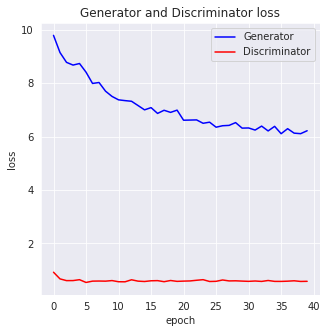

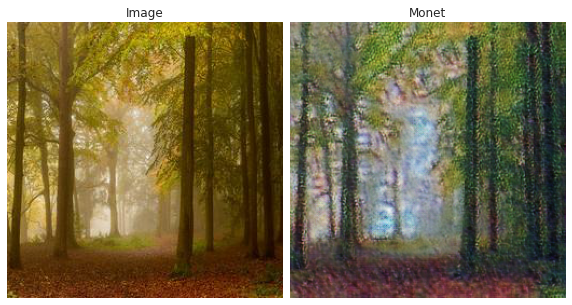

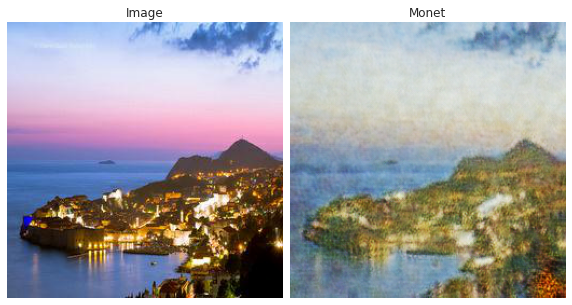

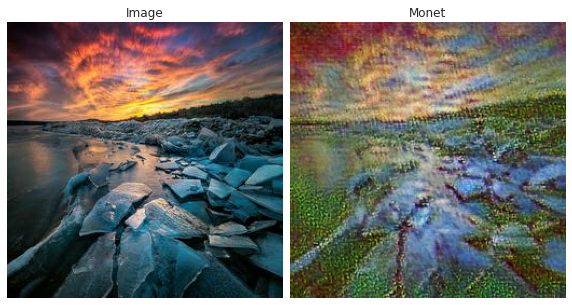

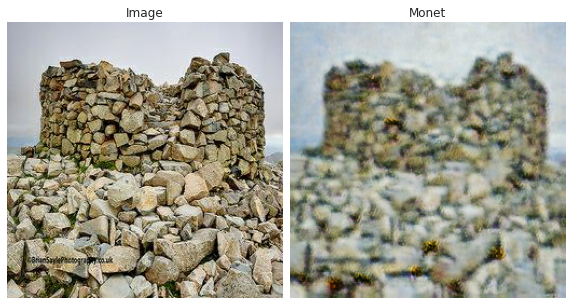

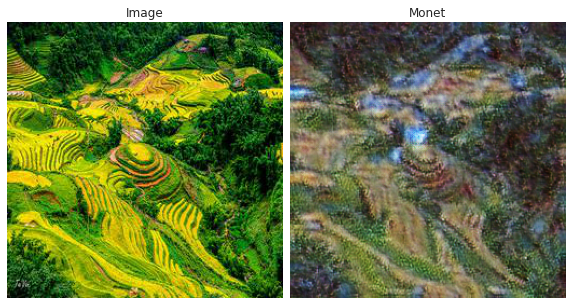

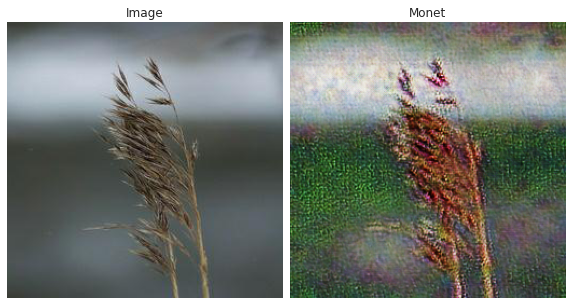

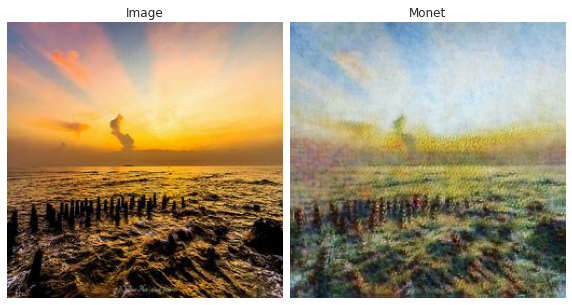

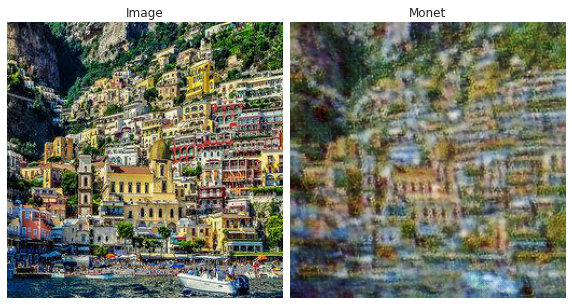

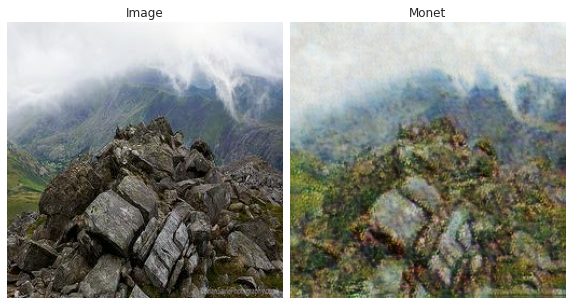

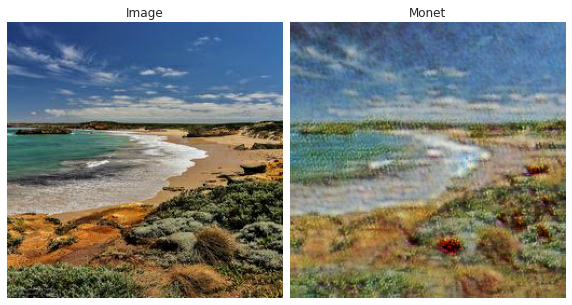

In [34]:
print("Start learning on %s..." % device)
for epoch in range(start_epoch, EPOCHS+1):
    avgG_loss = 0
    avgD_loss = 0
    dataset.set_train_mode()
    tqdm_dataloader = tqdm(
        dataloader, leave=False, total=len(dataloader))
    for i, (photo, monet) in enumerate(tqdm_dataloader):
        photo = photo.to(device)
        monet = monet.to(device)
        # Generator training
        optimizerG.zero_grad()
        
        fake_monet = G(photo)
        fake_photo = F(monet)
        
        cycle_monet = G(fake_photo)
        cycle_photo = F(fake_monet)
        
        identity_monet = G(monet)
        identity_photo = F(photo)
        
        D_fake_monet = D_y(fake_monet)
        D_fake_photo = D_x(fake_photo)
        
        real = get_real(D_fake_monet.size()).to(device)
        
        adversary_loss = mse_loss(D_fake_monet, real) + mse_loss(D_fake_photo, real)
        cycle_loss = l1_loss(cycle_photo, photo) + l1_loss(cycle_monet, monet)
        identity_loss = l1_loss(identity_monet, monet) + l1_loss(identity_photo, photo)
        
        loss = adversary_loss + LAMBDA*(cycle_loss + IDENTITY_COEF*identity_loss)
        avgG_loss += loss.item()
        
        loss.backward()
        optimizerG.step()
        
        # Discriminator training
        optimizerD.zero_grad()
        
        fake_monet = fake_samples_monet(fake_monet.detach().cpu()).to(device)
        fake_photo = fake_samples_photo(fake_photo.detach().cpu()).to(device)
        
        fake = get_fake(D_fake_monet.size()).to(device)
        
        real, fake = random_swap(real, fake, p=DISCRIMINATOR_LABEL_SWAP_P)

        adversary_monet_loss = mse_loss(D_y(monet), real) + mse_loss(D_y(fake_monet), fake)
        adversary_photo_loss = mse_loss(D_x(photo), real) + mse_loss(D_x(fake_photo), fake)
        loss = adversary_monet_loss + adversary_photo_loss
        avgD_loss += loss.item()
        
        loss.backward()
        optimizerD.step()
        
        # logs
        tqdm_dataloader.set_postfix(
            D_loss=avgD_loss/(i+1),
            G_loss=avgG_loss/(i+1),
        )
        
    avgG_loss /= len(dataloader)
    avgD_loss /= len(dataloader)
    
    history["gen_loss"].append(avgG_loss)
    history["dis_loss"].append(avgD_loss)
    
    print(
        "Epoch %d | Generator Loss = %.4f | Distriminator Loss = %.4f" \
        % (epoch, avgG_loss, avgD_loss)
    )
    if SAVE_MODEL_DIR is not None:
        state = dict(
            epoch=epoch,
            history=history,
            G=G.state_dict(), 
            F=F.state_dict(), 
            D_x=D_x.state_dict(), 
            D_y=D_y.state_dict(), 
            optimizerG=optimizerG.state_dict(), 
            optimizerD=optimizerD.state_dict(),
        )
        fn = "current"
        path = os.path.join(SAVE_MODEL_DIR, fn)
        save_checkpoint(state, path)
    
    if epoch%UPDATE_EVERY_N == 0:
        clear_output(wait=True)
        plot_loss(history["gen_loss"], history["dis_loss"], (5, 5))
        dataset.set_test_mode()
        for idx in range(N_SAMPLES):
            with torch.no_grad():
                photo = dataset_photos[idx][None, ...].to(device)
                display_pair(to_img(photo[0]), to_img(G(photo)[0]))
    
    scheduleG.step()
    scheduleD.step()

## Make submission

In [35]:
gen_images = []
photo_dataloader = DataLoader(dataset_photos, batch_size=1, num_workers=WORKERS)
dataset.set_test_mode()
with torch.no_grad():
    for img in tqdm(photo_dataloader):
        gen = G(img.to(device))[0]
        # unnormalize
        gen_images.append(to_img(gen))
dataset.set_train_mode()

  0%|          | 0/7038 [00:00<?, ?it/s]

In [36]:
def viz_gen_images(gen_images, n_samples=10):
    for idx in np.random.permutation(len(gen_images))[:n_samples]:
        print(idx)
        display(gen_images[idx])

4534


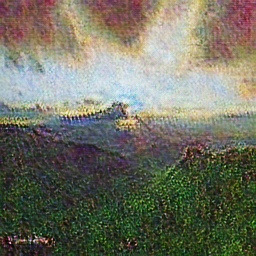

317


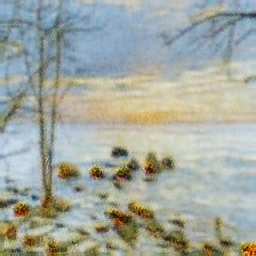

1900


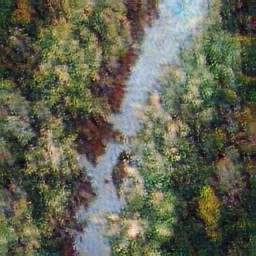

2


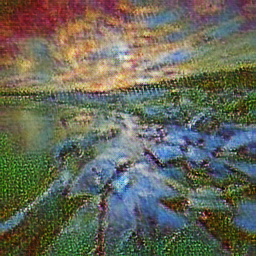

2826


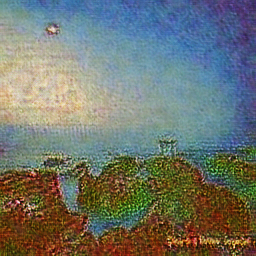

3716


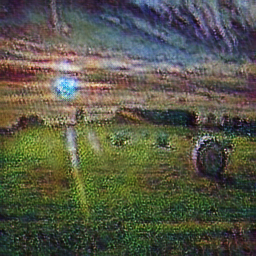

5797


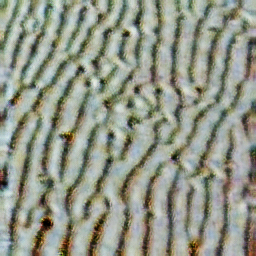

6409


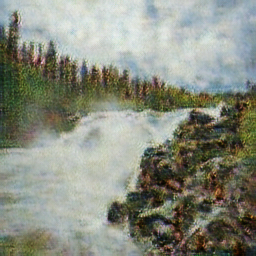

380


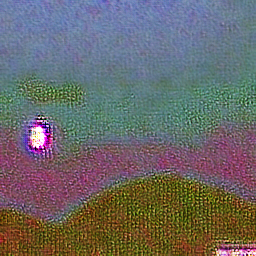

3304


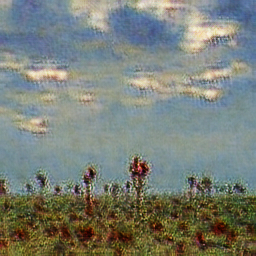

In [37]:
viz_gen_images(gen_images, 10)

In [38]:
for i, gen in enumerate(gen_images):
    gen.save("./images/" + str(i+1) + ".jpg")

In [39]:
len(os.listdir("./images"))

7038

In [40]:
import shutil
shutil.make_archive("./images", 'zip', "./images")

'/kaggle/working/images.zip'